`А=C*МС+D*MM*a-B*MT;                                     
MА=max(B-D)*MD*MT-MC*(MT+MM).
`



In [1]:
import logging
import random
import time
import json
import os.path
import matplotlib.pyplot as plt
from os import path
from threading import Thread, Lock

Константи

In [2]:
MAX_FLOAT = 5000.0
MIN_FLOAT = 0.0
MIN_DIMENSION = 100
MAX_DIMENSION = 140
FILE_IN_PATH = 'data.json'
FILE_OUT_PATH = 'result_v2.txt'

Функції для генерування, запису/зчитування даних

In [3]:
def randomFloat():
  return random.uniform(MIN_FLOAT, MAX_FLOAT);

def createVector(dim: int):
  vector = []
  for i in range(dim):
    vector.append(round(randomFloat(), random.randint(1, 10)))

  return vector

def createMatrix(rows: int, cols: int):
  matrix = []
  for i in range(rows):
    matrix.append(createVector(cols))
  return matrix

def generateInputData(dim_list, path):
  json_array = []

  for i in range(len(dim_list)):
    dim = dim_list[i]

    json_data = {
      'a': randomFloat(),
      'C': createVector(dim),
      'D': createVector(dim),
      'B': createVector(dim),
      'MC': createMatrix(dim, dim),
      'MD': createMatrix(dim, dim),
      'MM': createMatrix(dim, dim),
      'MT': createMatrix(dim, dim)
    }

    json_array.append(json_data)

  with open(path, 'w') as f:
    json.dump(json_array, f)

def importInputData(path):
  with open(path, 'r') as f:
    data = json.load(f)
  
  return data

def storeResults(path, result, fn_name):
  with open(path, 'a') as f:
    serealized = json.dumps(result, separators=(',', ':'))
    f.write(f'{fn_name} {serealized}\n')
    f.close()

Функції для виводу в консоль/файл

In [4]:
lock = Lock() # аналог Lock із пакета java.util.concurrent.lock

In [5]:
def is_2d_array(arr):
  if not isinstance(arr, list):
    return False

  for item in arr:
    if not isinstance(item, (list, tuple)):
      return False

  return True

def print_synchronized(fn_name, path, result):
  lock.acquire()

  # Print the message to the console and save it to a file 
  # (in the case of a matrix, only the first row is displayed 
  # in the console for easy display)
  storeResults(path, result, fn_name)
  print(f"{fn_name} {is_2d_array(result) and result[0] or result}")
  lock.release()

Допоміжні математичні функції

In [6]:
def sum_kahan(*n):
    sum = 0.0
    x = 0.0

    for i in range(len(n)):
        y = n[i] - x
        z = sum + y
        x = (z - sum) - y
        sum = z

    return sum

def matrix_mul_partial(matrix1, matrix2, resMatrix, end, start=0):
  for i in range(start, end):
    for j in range(len(matrix2[0])):
      sum = 0.0
      for k in range(len(matrix1[0])):
        sum = sum_kahan(sum, matrix1[i][k] * matrix2[k][j])
      lock.acquire()
      resMatrix[i][j] = sum
      lock.release()

def vector_mul_matrix_partial(vector, matrix, result_vector, end, start=0):
  for i in range(start, end):
    result_vector[i] = 0.0
    for j in range(len(vector)):
      lock.acquire()
      result_vector[i] = sum_kahan(result_vector[i], vector[j] * matrix[j][i])
      lock.release()

def add_matrices(matrix1, matrix2):
  result = []
  for i in range(len(matrix1)):
    row = []
    for j in range(len(matrix1[0])):
      row.append(matrix1[i][j] + matrix2[i][j])
    result.append(row)
  return result

def subtract_matrices(matrix1, matrix2):
  result = []
  for i in range(len(matrix1)):
    row = []
    for j in range(len(matrix1[0])):
      row.append(matrix1[i][j] - matrix2[i][j])
    result.append(row)
  return result

def multiply_matrices(matrix1, matrix2):
  result = []
  for i in range(len(matrix1)):
    row = []
    for j in range(len(matrix2[0])):
      sum = 0.0
      for k in range(len(matrix2)):
        sum = sum_kahan(sum, matrix1[i][k] * matrix2[k][j])
      row.append(sum)
    result.append(row)
  return result

def matrix_mul_scalar(matrix, scalar):
  result = []
  for row in matrix:
    new_row = [elem * scalar for elem in row]
    result.append(new_row)

  return result

def vector_mul_matrix(vector, matrix):
  result = []
  for i in range(len(matrix[0])):
    value = 0.0
    for j in range(len(vector)):
      value = sum_kahan(value, vector[j] * matrix[j][i])
    result.append(value)

  return result

def add_vectors(vector1, vector2):
  if len(vector1) != len(vector2):
    raise ValueError("Vectors must have the same length")
  result = []
  for i in range(len(vector1)):
    result.append(vector1[i] + vector2[i])

  return result

def subtract_vectors(vector1, vector2):
  if len(vector1) != len(vector2):
    raise ValueError("Vectors must have the same length")
  result = []
  for i in range(len(vector1)):
    result.append(vector1[i] - vector2[i])

  return result

def vector_mul_scalar(vector, scalar):
  return [elem * scalar for elem in vector]

Математичні функції для обчислення виразів

In [7]:
class Variant8Functions:
  resAPart1 = None # C*МС
  resAPart2 = None # D*MM
  resAPart3 = None # B*MT

  resMAPart1 = None # MD*MT
  resMAPart2 = None # MC*(MT+MM)

  def __init__(self, data) -> None:
    self.a = data['a']
    self.C = data['C']
    self.D = data['D']
    self.B = data['B']
    self.MC = data['MC']
    self.MD = data['MD']
    self.MM = data['MM']
    self.MT = data['MT']

    self.resAPart1 = [0] * len(self.C)
    self.resAPart2 = [0] * len(self.C)
    self.resAPart3 = [0] * len(self.C)
    self.resMAPart1 = [[0 for j in range(len(self.MC))] for i in range(len(self.MC))]
    self.resMAPart2 = [[0 for j in range(len(self.MC))] for i in range(len(self.MC))]

  def __get_intervals(self, length, thrCount):
    step = length // thrCount
    breakpoints = [0] + [step*i for i in range(1, thrCount)] + [length]
    return [(breakpoints[i], breakpoints[i+1]) for i in range(len(breakpoints)-1)]

  # А=C*МС+D*MM*a-B*MT
  def mathFunction1Paralel(self, thrCount):
    length = len(self.C)
    intervals = self.__get_intervals(length, thrCount)
    threads = []

    for interval in intervals:
      threads.append(Thread(target=vector_mul_matrix_partial, args=[self.C, self.MC, self.resAPart1, interval[1], interval[0]])) # C*МС
      threads.append(Thread(target=vector_mul_matrix_partial, args=[self.D, self.MM, self.resAPart2, interval[1], interval[0]])) # D*MM
      threads.append(Thread(target=vector_mul_matrix_partial, args=[self.B, self.MT, self.resAPart3, interval[1], interval[0]])) # B*MT

    for thr in threads:
      thr.start()
    
    for thr in threads:
      thr.join()

    return subtract_vectors(
        add_vectors(self.resAPart1, vector_mul_scalar(self.resAPart2, self.a)),
        self.resAPart3
    )

  # MА=max(B-D)*MD*MT-MC*(MT+MM)
  def mathFunction2Paralel(self, thrCount):
    length = len(self.MC)
    intervals = self.__get_intervals(length, thrCount)
    threads = []

    maxScalar = max(subtract_vectors(self.B, self.D)) # max(B-D)
    sumMM_MT = add_matrices(self.MT, self.MM)
    

    for interval in intervals:
      threads.append(Thread(target=matrix_mul_partial, args=[self.MD, self.MT, self.resMAPart1, interval[1], interval[0]])) # MD*MT
      threads.append(Thread(target=matrix_mul_partial, args=[self.MC, sumMM_MT, self.resMAPart2, interval[1], interval[0]])) # MC*(MT+MM)
    
    for thr in threads:
      thr.start()
    
    for thr in threads:
      thr.join()

    return subtract_matrices(
        matrix_mul_scalar(self.resMAPart1, maxScalar),
        self.resMAPart2
    )


  def mathFunction1WithTimeFixation(self, thrCount, timing, iter):
    startTime = time.time()
    resultA = self.mathFunction1Paralel(thrCount)
    endTime = time.time()
  
    timing[iter] = endTime - startTime
    print_synchronized(f'A iteration {iter}:', FILE_OUT_PATH, resultA)

  def mathFunction2WithTimeFixation(self, thrCount, timing, iter):
    startTime = time.time()
    resultMA = self.mathFunction2Paralel(thrCount)
    endTime = time.time()
  
    timing[iter] = endTime - startTime
    print_synchronized(f'MA iteration {iter}:', FILE_OUT_PATH, resultMA)  

Main

In [8]:
cols_dim = [i for i in range(MIN_DIMENSION, MAX_DIMENSION)]
timingMA = [None] * len(cols_dim)
timingA = [None] * len(cols_dim)
threadCountA = 4
threadCountMA = 10

if not path.exists(FILE_IN_PATH):
  generateInputData(cols_dim, FILE_IN_PATH)

data = importInputData(FILE_IN_PATH)

for i in range(len(data)):
  mf = Variant8Functions(data[i])
  
  task2 = Thread(target=mf.mathFunction2WithTimeFixation, args=[threadCountMA, timingMA, i])
  task2.start()
  
  mf.mathFunction1WithTimeFixation(threadCountA, timingA, i)

  task2.join()

A iteration 0: [461440449925.77716, 480498326086.95435, 546104763287.8609, 493680900585.5861, 526756827993.77313, 529438405547.25116, 432540547508.0012, 476051460406.68207, 501922597862.668, 477412387294.64453, 525814082690.4246, 489515869967.307, 510578635258.709, 549859449150.867, 492220921799.78796, 453093197546.52716, 463178066420.28864, 540238049701.61615, 492466578459.6896, 486579953146.27893, 460844021074.2157, 464220962055.0196, 450342125492.88873, 461407176872.45734, 491639542894.2918, 447660917030.1573, 495656899608.8975, 499079932463.65753, 495215103830.34436, 462785560907.4727, 468606086696.86273, 481626386264.411, 472616042741.69806, 501615904210.1926, 539170237571.4884, 492692515305.5346, 445362269756.7578, 461997890991.47644, 516346583354.94305, 505167992968.4869, 517945879102.44855, 483569514554.78784, 549551334982.76624, 531424864664.9607, 479434405480.93256, 495310518352.5243, 530280677401.3114, 487414376413.21356, 517449239758.59174, 556560071374.005, 486754342375.99

Графіки залежності часу від розмірності для обох функцій

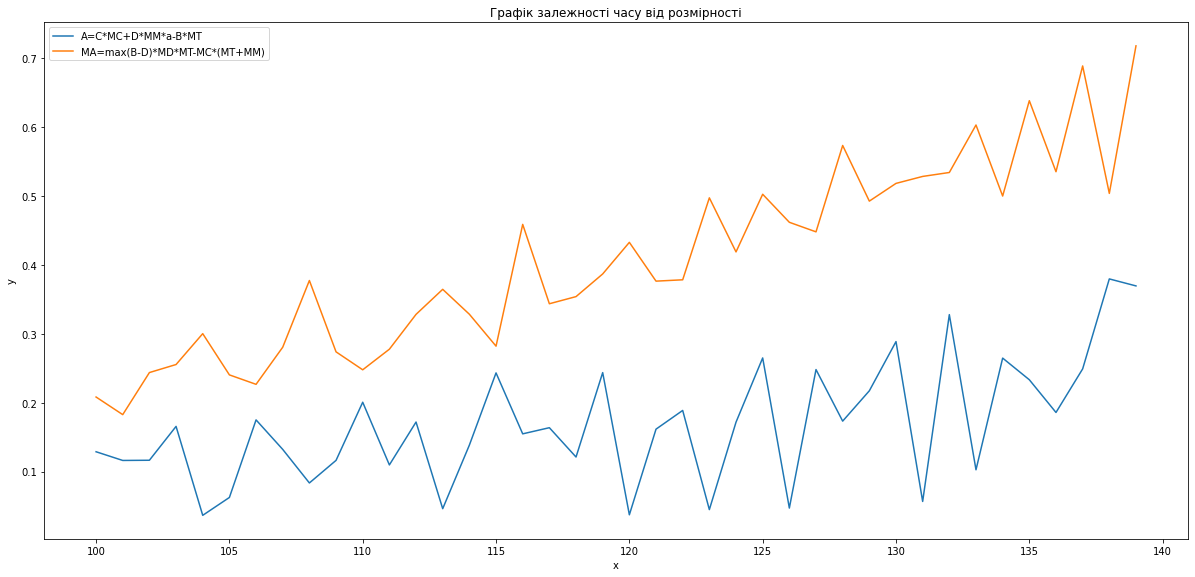

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(cols_dim, timingA, label='А=C*МС+D*MM*a-B*MT')
ax.plot(cols_dim, timingMA, label='MА=max(B-D)*MD*MT-MC*(MT+MM)')
ax.set_title('Графік залежності часу від розмірності')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()